In [12]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
import random

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 100
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.MIPFocus = 1
    model.Params.Heuristics = 0.8
    model.Params.Threads = 8

In [13]:
# Parameters
m = 8
K = 5
L_levels = [25, 20, 15, 12, 10]
E_levels = [13, 28, 38, 45, 120] 
E_PU_max = [5800] * m 
CPU_capacity = [3000] * m
f_v_levels = [30, 40, 60, 80, 100]
P_idle = [16] * m
P_max = [40] * m
T_total = 300
total_tasks = 150
from collections import Counter

# Task chain definitions
chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}

num_chains = len(chain_tasks)
n = max(max(v) for v in chain_tasks.values()) + 1  # Total number of tasks
buffer = 0.2  
L_max = [int(len(chain_tasks[k]) * min(L_levels) * (1 + buffer)) for k in chain_tasks]


In [14]:


def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=None):
    model = gp.Model("MAF_Optimization")
    configure_model(model)
    if E_PU_max is None:
        E_PU_max = [8000] * m  

    
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")

    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # Ensure y[i,k]=0 if task is inactive

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])

    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )


    model.write("model_before_optimize.lp") 
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    model.write("model_after_optimize.lp")   


    if model.status == GRB.INFEASIBLE:
        print("🚫 Infeasible model! Computing IIS...")
        model.computeIIS()
        model.write("model_infeasible.ilp")
        print("\n🚨 Infeasible Constraints in IIS:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(f" - {c.constrName}")
        return None

    if model.status != GRB.OPTIMAL:
        print("❌ Model optimization failed (status =", model.status, ").")
        return None


    print(f"⏱️ Gurobi Runtime: {end_time - start_time:.2f} seconds")
    print("\n📋 Chain Activation Overview:")
    for k in range(num_chains):
        status = "✅ Activated" if z[k].X > 0.5 else "❌ Not activated"
        task_list = chain_tasks[k]
        print(f"Chain {k}: {status}, Tasks: {task_list}")

    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
        pu_task_map.setdefault(pu_id, []).append(task_id)

    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]
    

    return {
        "Mode": "Baseline" if baseline else "Non-Baseline",
        "Objective Value": model.ObjVal,
        "Accepted Chains": len(accepted_chains),
        "Total PU Energy": sum(E_PU[j].X for j in range(m)),
        "Total Task Energy": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
        "Runtime": model.Runtime,
        "PU Task Assignment": pu_task_map,
        "Task Energy Levels": task_energy_levels,
        "Activated Chain List": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)],
        "Total Chains": num_chains 
    }

In [15]:
def run_heuristic_model_with_diagnostics(alpha_1=2500, alpha_2=10, alpha_3=1, baseline=False):
    import time
    start_time = time.time()

    delta = [0] * n
    y = [-1] * n
    w = [-1] * n
    z = [0] * num_chains

    pu_remaining_cpu = CPU_capacity[:]
    pu_workload = [0] * m
    accepted_chains = 0

    task_energy_levels = [-1] * n
    pu_task_map = {j: [] for j in range(m)}

    print("\n===== [Greedy 链诊断信息] =====")
    for k in range(num_chains):
        task_list = chain_tasks[k]
        task_energy_per_chain = []
        task_cpu_usage = []
        chain_latency = 0
        chain_cpu = 0
        feasible = True

        for i in task_list:
            assigned = False

            if baseline:
                level = K - 1  # 强制最高能耗等级
                latency = L_levels[level]
                cpu = f_v_levels[level]
                task_energy_per_chain.append(level)
                task_cpu_usage.append(cpu)
                chain_latency += latency
                chain_cpu += cpu
                assigned = True
            else:
                for level in reversed(range(K)):  # 从低延迟等级开始
                    latency = L_levels[level]
                    cpu = f_v_levels[level]
                    task_energy_per_chain.append(level)
                    task_cpu_usage.append(cpu)
                    chain_latency += latency
                    chain_cpu += cpu
                    assigned = True
                    break

            if not assigned:
                feasible = False
                break

        total_chain_latency = chain_latency + (len(task_list) - 1)
        if not feasible or total_chain_latency > L_max[k]:
            print(f"❌ 链 {k} 被跳过：延迟约束不满足（总延迟 ≈ {total_chain_latency}, 上限 = {L_max[k]}）")
            continue

        assigned_to_pu = False
        for j in range(m):

            if pu_remaining_cpu[j] >= chain_cpu:

                new_workload = pu_workload[j] + sum(L_levels[task_energy_per_chain[idx]] for idx in range(len(task_list)))
                new_pu_energy = P_idle[j] * (T_total - new_workload) + (P_max[j] - P_idle[j]) * new_workload
                if new_pu_energy > E_PU_max[j]:
                    continue  


                for idx, i in enumerate(task_list):
                    delta[i] = 1
                    y[i] = task_energy_per_chain[idx]
                    w[i] = j
                    task_energy_levels[i] = task_energy_per_chain[idx]
                    pu_task_map[j].append(i)
                    pu_remaining_cpu[j] -= task_cpu_usage[idx]
                    pu_workload[j] += L_levels[task_energy_per_chain[idx]]
                z[k] = 1
                accepted_chains += 1
                assigned_to_pu = True
                print(f"✅ Chain {k} activated (PU {j}, total latency = {total_chain_latency}, total CPU = {chain_cpu})")
                break

        if not assigned_to_pu:
            print(f"❌ Chain {k} skipped: latency ok but all PUs exceed energy/resource limits (CPU = {chain_cpu})")


    maf_energy = sum(E_levels[y[i]] for i in range(n) if y[i] != -1)
    pu_energy = sum(
        P_idle[j] * (T_total - pu_workload[j]) +
        (P_max[j] - P_idle[j]) * pu_workload[j]
        for j in range(m)
    )
    total_energy = maf_energy + pu_energy
    acceptance_rate = accepted_chains / num_chains
    runtime = time.time() - start_time
    objective = alpha_1 * sum(z) - alpha_2 * maf_energy - alpha_3 * pu_energy

    print(f"\n✅ Greedy Summary: Accepted {accepted_chains}/{num_chains} chains, acceptance_rate = {acceptance_rate:.2%}")

    return {
        "objective": objective,
        "acceptance_rate": acceptance_rate,
        "total_energy": total_energy,
        "runtime": runtime,
        "details": {
            "mode": "Baseline" if baseline else "Non-Baseline",
            "accepted_chains": accepted_chains,
            "total_pu_energy": pu_energy,
            "total_task_energy": maf_energy,
            "activated_chain_list": z,
            "task_energy_levels": task_energy_levels,
            "pu_task_assignment": pu_task_map
        }
    }




In [16]:
import matplotlib.pyplot as plt

def plot_full_comparison(result_baseline, result_optimal, result_greedy):
    labels = ["Gurobi Baseline", "Gurobi Optimal", "Greedy"]

    # === 执行时间 ===
    times = [result_baseline["runtime"],
             result_optimal["runtime"],
             result_greedy["runtime"]]

    # === 接受率 ===
    acceptance = [result_baseline["acceptance_rate"],
                  result_optimal["acceptance_rate"],
                  result_greedy["acceptance_rate"]]

    # === 总能耗 ===
    energy_baseline = result_baseline["total_pu_energy"] + result_baseline["total_task_energy"]
    energy_optimal = result_optimal["total_pu_energy"] + result_optimal["total_task_energy"]
    energy_greedy = result_greedy["total_energy"]
    total_energy = [energy_baseline, energy_optimal, energy_greedy]

    # === 相对 Baseline 的节能百分比 ===
    saving_values = [
        0,
        (energy_baseline - energy_optimal) / energy_baseline * 100,
        (energy_baseline - energy_greedy) / energy_baseline * 100
    ]

    # === 绘图 ===
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # 1. 执行时间
    axs[0, 0].bar(labels, times, color=["orange", "skyblue", "green"])
    axs[0, 0].set_title("Execution Time (s)")
    for i, v in enumerate(times):
        axs[0, 0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

    # 2. 接受率
    axs[0, 1].bar(labels, acceptance, color=["orange", "skyblue", "green"])
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylim(0, 1)
    for i, v in enumerate(acceptance):
        axs[0, 1].text(i, v, f"{v:.1%}", ha='center', va='bottom')

    # 3. 总能耗
    axs[1, 0].bar(labels, total_energy, color=["orange", "skyblue", "green"])
    axs[1, 0].set_title("Total Energy Consumption")
    for i, v in enumerate(total_energy):
        axs[1, 0].text(i, v, f"{v:.1f}", ha='center', va='bottom')

    # 4. 节能百分比
    axs[1, 1].bar(labels, saving_values, color=["orange", "skyblue", "green"])
    axs[1, 1].set_title("Energy Savings Compared to Baseline (%)")
    axs[1, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
    for i, v in enumerate(saving_values):
        axs[1, 1].text(i, v, f"{v:.2f}%", ha='center', va='bottom')

    fig.tight_layout()
    plt.show()




⏱️ Gurobi Runtime: 0.06 seconds

📋 Chain Activation Overview:
Chain 0: ✅ Activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ✅ Activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ✅ Activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ✅ Activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ✅ Activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ✅ Activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ✅ Activated, Tasks: [64, 65, 66]
Chain 9: ✅ Activated, Tasks: [67, 68, 69]
Chain 10: ✅ Activated, Tasks: [70, 71, 72]
Chain 11: ✅ Activated, Tasks: [73, 74, 75]
Chain 12: ✅ Activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Chain 14: ✅ Activated, Tasks: [82, 83, 84]
Chain 15: ✅ Activated, Tasks: [85, 86, 87]
Chain 16: ✅ Activated, Tasks: [88, 89, 90]
Chain 17: ✅ Activated, Tasks: [91, 92, 93]
Chain 18: ✅ Activated, T

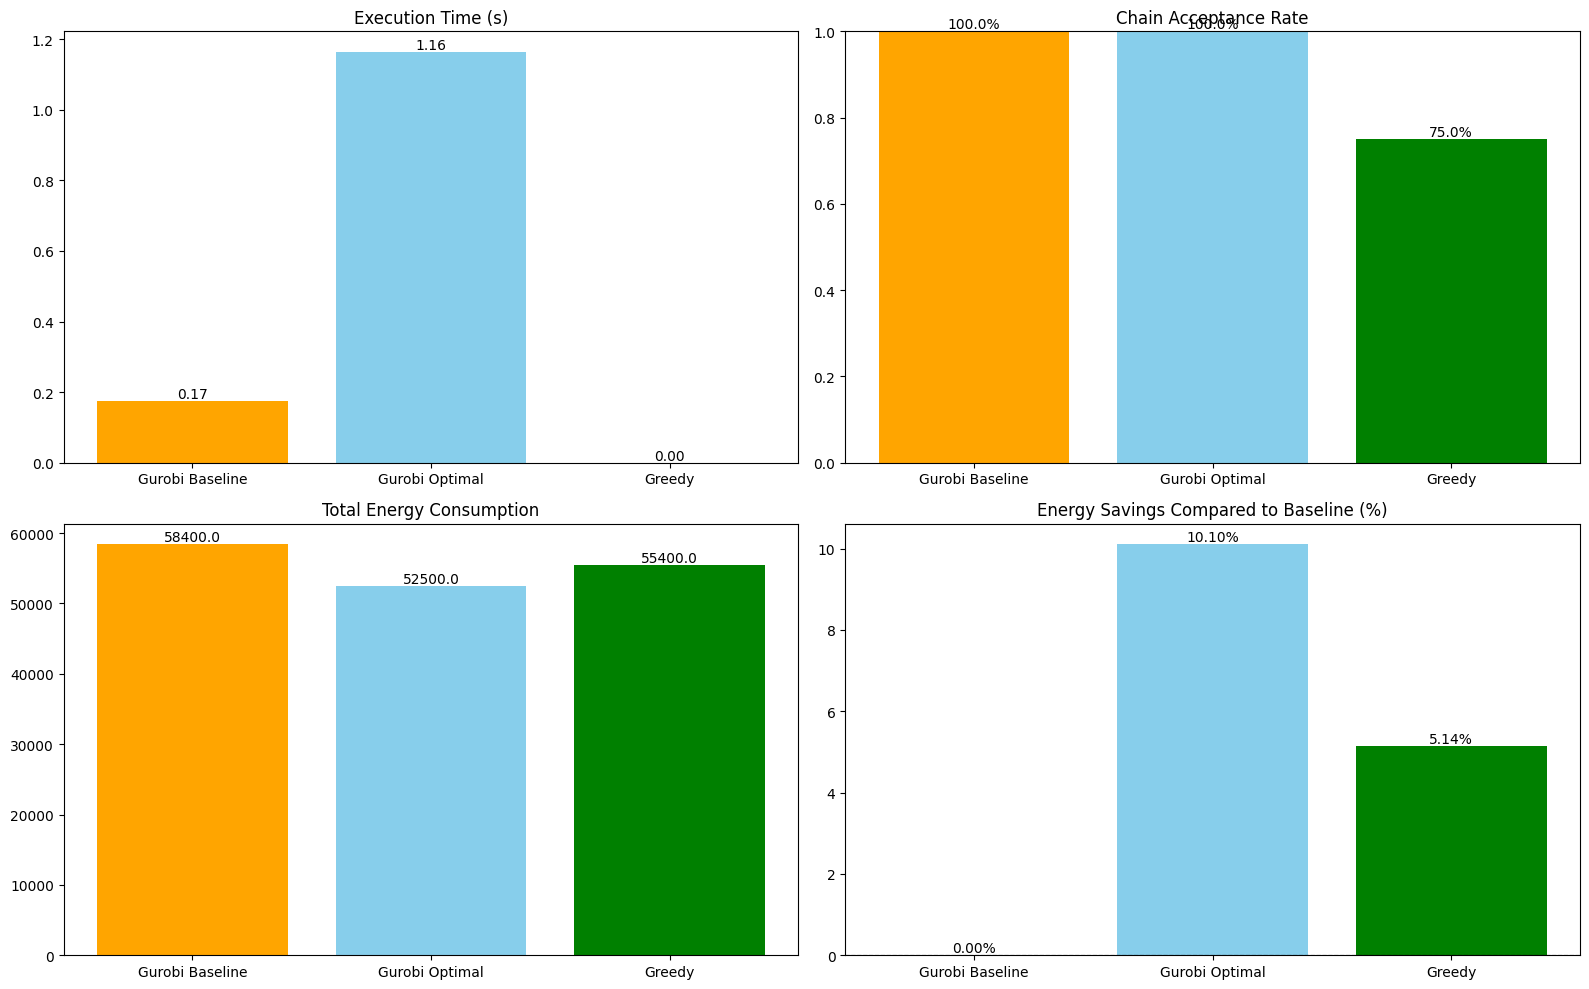

In [17]:

alpha_1 = 8000
alpha_2 = 3
alpha_3 = 1

# === Gurobi Baseline ===
start = time.time()
result_baseline = run_gurobi_model(alpha_1=alpha_1, alpha_2=alpha_2, alpha_3=alpha_3, baseline=True)
result_baseline["runtime"] = time.time() - start
result_baseline["acceptance_rate"] = result_baseline["Accepted Chains"] / result_baseline["Total Chains"]
result_baseline["total_pu_energy"] = result_baseline["Total PU Energy"]
result_baseline["total_task_energy"] = result_baseline["Total Task Energy"]

# === Gurobi Optimal ===
start = time.time()
result_optimal = run_gurobi_model(alpha_1=alpha_1, alpha_2=alpha_2, alpha_3=alpha_3, baseline=False)
result_optimal["runtime"] = time.time() - start
result_optimal["acceptance_rate"] = result_optimal["Accepted Chains"] / result_optimal["Total Chains"]
result_optimal["total_pu_energy"] = result_optimal["Total PU Energy"]
result_optimal["total_task_energy"] = result_optimal["Total Task Energy"]

# === Greedy ===
result_greedy = run_heuristic_model_with_diagnostics(alpha_1=8000, alpha_2=3, alpha_3=1, baseline=False)


plot_full_comparison(result_baseline, result_optimal, result_greedy)





In [18]:
print("Greedy acceptance_rate =", result_greedy.get("acceptance_rate"))
print("Greedy runtime =", result_greedy.get("runtime"))

Greedy acceptance_rate = 0.75
Greedy runtime = 0.0004391670227050781


In [19]:
def run_heuristic_model_with_diagnostics(alpha_1=2500, alpha_2=10, alpha_3=1, baseline=False):
    import time
    start_time = time.time()

    delta = [0] * n
    y = [-1] * n
    w = [-1] * n
    z = [0] * num_chains

    pu_remaining_cpu = CPU_capacity[:]
    pu_workload = [0] * m
    accepted_chains = 0

    task_energy_levels = [-1] * n
    pu_task_map = {j: [] for j in range(m)}

   
    for k in range(num_chains):
        task_list = chain_tasks[k]
        task_energy_per_chain = []
        task_cpu_usage = []
        chain_latency = 0
        chain_cpu = 0
        feasible = True

        for i in task_list:
            assigned = False

            if baseline:
                level = K - 1  # 强制最高能耗等级
                latency = L_levels[level]
                cpu = f_v_levels[level]
                task_energy_per_chain.append(level)
                task_cpu_usage.append(cpu)
                chain_latency += latency
                chain_cpu += cpu
                assigned = True
            else:
                for level in reversed(range(K)):  # 从低延迟等级开始
                    latency = L_levels[level]
                    cpu = f_v_levels[level]
                    task_energy_per_chain.append(level)
                    task_cpu_usage.append(cpu)
                    chain_latency += latency
                    chain_cpu += cpu
                    assigned = True
                    break

            if not assigned:
                feasible = False
                break

        total_chain_latency = chain_latency + (len(task_list) - 1)
        if not feasible or total_chain_latency > L_max[k]:
            print(f"❌ 链 {k} 被跳过：延迟约束不满足（总延迟 ≈ {total_chain_latency}, 上限 = {L_max[k]}）")
            continue

        assigned_to_pu = False
        for j in range(m):

            if pu_remaining_cpu[j] >= chain_cpu:

                new_workload = pu_workload[j] + sum(L_levels[task_energy_per_chain[idx]] for idx in range(len(task_list)))
                new_pu_energy = P_idle[j] * (T_total - new_workload) + (P_max[j] - P_idle[j]) * new_workload
                if new_pu_energy > E_PU_max[j]:
                    continue  


                for idx, i in enumerate(task_list):
                    delta[i] = 1
                    y[i] = task_energy_per_chain[idx]
                    w[i] = j
                    task_energy_levels[i] = task_energy_per_chain[idx]
                    pu_task_map[j].append(i)
                    pu_remaining_cpu[j] -= task_cpu_usage[idx]
                    pu_workload[j] += L_levels[task_energy_per_chain[idx]]
                z[k] = 1
                accepted_chains += 1
                assigned_to_pu = True
                print(f"✅ Chain {k} activated (PU {j}, total latency = {total_chain_latency}, total CPU = {chain_cpu})")
                break

        if not assigned_to_pu:
            print(f"❌ Chain {k} skipped: latency ok but all PUs exceed energy/resource limits (CPU = {chain_cpu})")


    maf_energy = sum(E_levels[y[i]] for i in range(n) if y[i] != -1)
    pu_energy = sum(
        P_idle[j] * (T_total - pu_workload[j]) +
        (P_max[j] - P_idle[j]) * pu_workload[j]
        for j in range(m)
    )
    total_energy = maf_energy + pu_energy
    acceptance_rate = accepted_chains / num_chains
    runtime = time.time() - start_time
    objective = alpha_1 * sum(z) - alpha_2 * maf_energy - alpha_3 * pu_energy

    print(f"\n✅ Greedy Summary: Accepted {accepted_chains}/{num_chains} chains, acceptance_rate = {acceptance_rate:.2%}")

    return {
        "objective": objective,
        "acceptance_rate": acceptance_rate,
        "total_energy": total_energy,
        "runtime": runtime,
        "details": {
            "mode": "Baseline" if baseline else "Non-Baseline",
            "accepted_chains": accepted_chains,
            "total_pu_energy": pu_energy,
            "total_task_energy": maf_energy,
            "activated_chain_list": z,
            "task_energy_levels": task_energy_levels,
            "pu_task_assignment": pu_task_map
        }
    }




In [20]:
result_greedy = run_heuristic_model_with_diagnostics(alpha_1=8000, alpha_2=3, alpha_3=1, baseline=False)


✅ Chain 0 activated (PU 0, total latency = 109, total CPU = 1000)
✅ Chain 1 activated (PU 1, total latency = 109, total CPU = 1000)
✅ Chain 2 activated (PU 2, total latency = 109, total CPU = 1000)
✅ Chain 3 activated (PU 3, total latency = 109, total CPU = 1000)
✅ Chain 4 activated (PU 4, total latency = 109, total CPU = 1000)
✅ Chain 5 activated (PU 5, total latency = 87, total CPU = 800)
✅ Chain 6 activated (PU 5, total latency = 32, total CPU = 300)
✅ Chain 7 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 8 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 9 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 10 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 11 activated (PU 7, total latency = 32, total CPU = 300)
✅ Chain 12 activated (PU 7, total latency = 32, total CPU = 300)
✅ Chain 13 activated (PU 7, total latency = 32, total CPU = 300)
✅ Chain 14 activated (PU 7, total latency = 32, total CPU = 300)
❌ Chain 15 skipped: laten

In [26]:
def visualize_baseline_vs_optimal_extended(baseline, optimal):

    def add_text(ax, x_pos, height, text, threshold=0, offset=5, y_max_ratio=0.95):
        if height > threshold:
            y_max = ax.get_ylim()[1]
            safe_y = min(height + offset, y_max * y_max_ratio)
            ax.text(x_pos, safe_y, str(text), ha='center', fontsize=10)

    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("Baseline vs Optimal Comparison Summary", fontsize=16, y=1.02)

    # 1. Execution Time
    axs[0, 0].bar(['Baseline', 'Optimal'], [baseline['Runtime'], optimal['Runtime']], color=['skyblue', 'orange'])
    axs[0, 0].set_title("Execution Time (s)")
    axs[0, 0].set_ylabel("Time (s)")
    for i, val in enumerate([baseline['Runtime'], optimal['Runtime']]):
        add_text(axs[0, 0], i, val, f"{val:.2f}", offset=0.03)

    # 2. Chain Acceptance Rate
    baseline_accept = baseline['Accepted Chains'] / baseline['Total Chains']
    optimal_accept = optimal['Accepted Chains'] / optimal['Total Chains']
    axs[0, 1].bar(['Baseline', 'Optimal'], [baseline_accept, optimal_accept], color=['skyblue', 'orange'])
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylabel("Ratio")
    for i, val in enumerate([baseline_accept, optimal_accept]):
        add_text(axs[0, 1], i, val, f"{val * 100:.1f}%", offset=0.03)

    # 3. Total Energy
    baseline_energy = baseline['Total PU Energy'] + baseline['Total Task Energy']
    optimal_energy = optimal['Total PU Energy'] + optimal['Total Task Energy']
    axs[0, 2].bar(['Baseline', 'Optimal'], [baseline_energy, optimal_energy], color=['skyblue', 'orange'])
    axs[0, 2].set_title("Total Energy Consumption")
    axs[0, 2].set_ylabel("Energy")
    for i, val in enumerate([baseline_energy, optimal_energy]):
        add_text(axs[0, 2], i, val, f"{val:.1f}", offset=3000)

    # 4. Energy Saving %
    saving_percent = (baseline_energy - optimal_energy) / baseline_energy * 100
    axs[1, 0].bar(['Baseline', 'Optimal'], [0, saving_percent], color=['skyblue', 'orange'])
    axs[1, 0].set_title("Energy Saving Compared to Baseline (%)")
    axs[1, 0].set_ylabel("Saving (%)")
    add_text(axs[1, 0], 1, saving_percent, f"{saving_percent:.2f}%", offset=0.5)

    # 5. Task Count per PU
    pu_task_count_baseline = [len(baseline['PU Task Assignment'].get(j, [])) for j in range(m)]
    pu_task_count_optimal = [len(optimal['PU Task Assignment'].get(j, [])) for j in range(m)]
    x = np.arange(m)
    axs[1, 1].bar(x - 0.2, pu_task_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 1].bar(x + 0.2, pu_task_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 1].set_title("Task Count per PU")
    axs[1, 1].set_xlabel("PU Index")
    axs[1, 1].set_ylabel("Task Count")
    axs[1, 1].legend()
    for i in x:
        add_text(axs[1, 1], i - 0.2, pu_task_count_baseline[i], pu_task_count_baseline[i])
        add_text(axs[1, 1], i + 0.2, pu_task_count_optimal[i], pu_task_count_optimal[i])

    # 6. Task Count per Energy Level
    energy_count_baseline = [baseline['Task Energy Levels'].count(k) for k in range(K)]
    energy_count_optimal = [optimal['Task Energy Levels'].count(k) for k in range(K)]
    x2 = np.arange(K)
    axs[1, 2].bar(x2 - 0.2, energy_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 2].bar(x2 + 0.2, energy_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 2].set_title("Task Count per Energy Level")
    axs[1, 2].set_xlabel("Energy Level")
    axs[1, 2].set_ylabel("Task Count")
    axs[1, 2].set_xticks(x2)
    axs[1, 2].set_xticklabels([f"Level {i+1}" for i in range(K)])
    axs[1, 2].legend()
    for i in x2:
        add_text(axs[1, 2], i - 0.2, energy_count_baseline[i], energy_count_baseline[i])
        add_text(axs[1, 2], i + 0.2, energy_count_optimal[i], energy_count_optimal[i])

    # 7. Objective Function Value
    axs[2, 0].bar(['Baseline', 'Optimal'], [baseline['Objective Value'], optimal['Objective Value']], color=['skyblue', 'orange'])
    axs[2, 0].set_title("Objective Function Value")
    axs[2, 0].set_ylabel("Value")
    for i, val in enumerate([baseline['Objective Value'], optimal['Objective Value']]):
        add_text(axs[2, 0], i, val, f"{val:.2f}", offset=3000)

    axs[2, 1].axis('off')
    axs[2, 2].axis('off')

    plt.tight_layout()
    plt.show()



def convert_result_for_visualization(result):
    return {
        'Runtime': result['runtime'],
        'Accepted Chains': result['details']['accepted_chains'],
        'Total Chains': len(result['details']['activated_chain_list']),
        'Total PU Energy': result['details']['total_pu_energy'],
        'Total Task Energy': result['details']['total_task_energy'],
        'PU Task Assignment': result['details']['pu_task_assignment'],
        'Task Energy Levels': result['details']['task_energy_levels'],
        'Objective Value': result['objective']
    }




In [28]:
print("Greedy runtime:", 'runtime' in result_greedy)
print("Optimal runtime:", 'runtime' in result_optimal)


Greedy runtime: True
Optimal runtime: False


✅ Chain 0 activated (PU 0, total latency = 109, total CPU = 1000)
✅ Chain 1 activated (PU 1, total latency = 109, total CPU = 1000)
✅ Chain 2 activated (PU 2, total latency = 109, total CPU = 1000)
✅ Chain 3 activated (PU 3, total latency = 109, total CPU = 1000)
✅ Chain 4 activated (PU 4, total latency = 109, total CPU = 1000)
✅ Chain 5 activated (PU 5, total latency = 87, total CPU = 800)
✅ Chain 6 activated (PU 5, total latency = 32, total CPU = 300)
✅ Chain 7 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 8 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 9 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 10 activated (PU 6, total latency = 32, total CPU = 300)
✅ Chain 11 activated (PU 7, total latency = 32, total CPU = 300)
✅ Chain 12 activated (PU 7, total latency = 32, total CPU = 300)
✅ Chain 13 activated (PU 7, total latency = 32, total CPU = 300)
✅ Chain 14 activated (PU 7, total latency = 32, total CPU = 300)
❌ Chain 15 skipped: laten

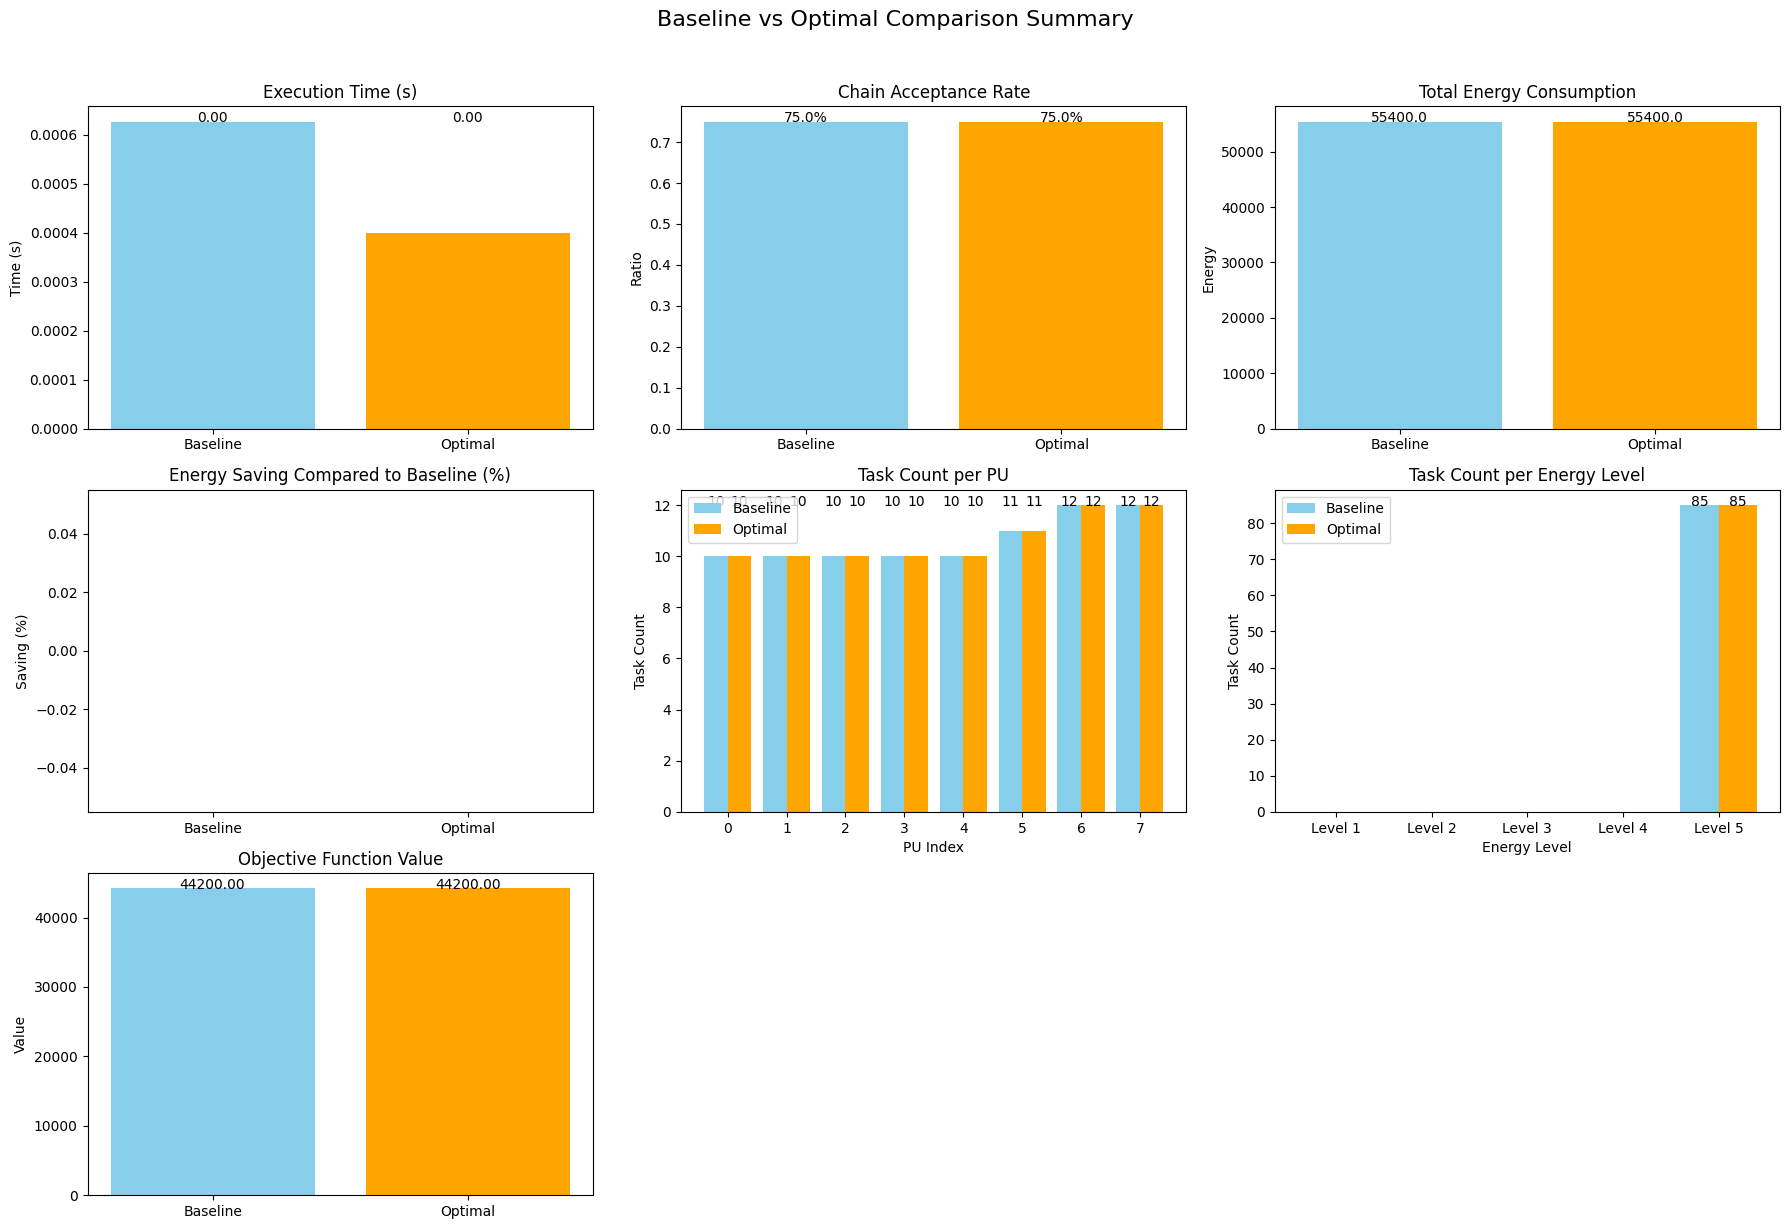

In [29]:

result_baseline = run_heuristic_model_with_diagnostics(alpha_1=8000, alpha_2=3, alpha_3=1, baseline=True)


result_greedy = run_heuristic_model_with_diagnostics(alpha_1=8000, alpha_2=3, alpha_3=1, baseline=False)



converted_baseline = convert_result_for_visualization(result_baseline)
converted_greedy = convert_result_for_visualization(result_greedy)


visualize_baseline_vs_optimal_extended(converted_baseline, converted_greedy)




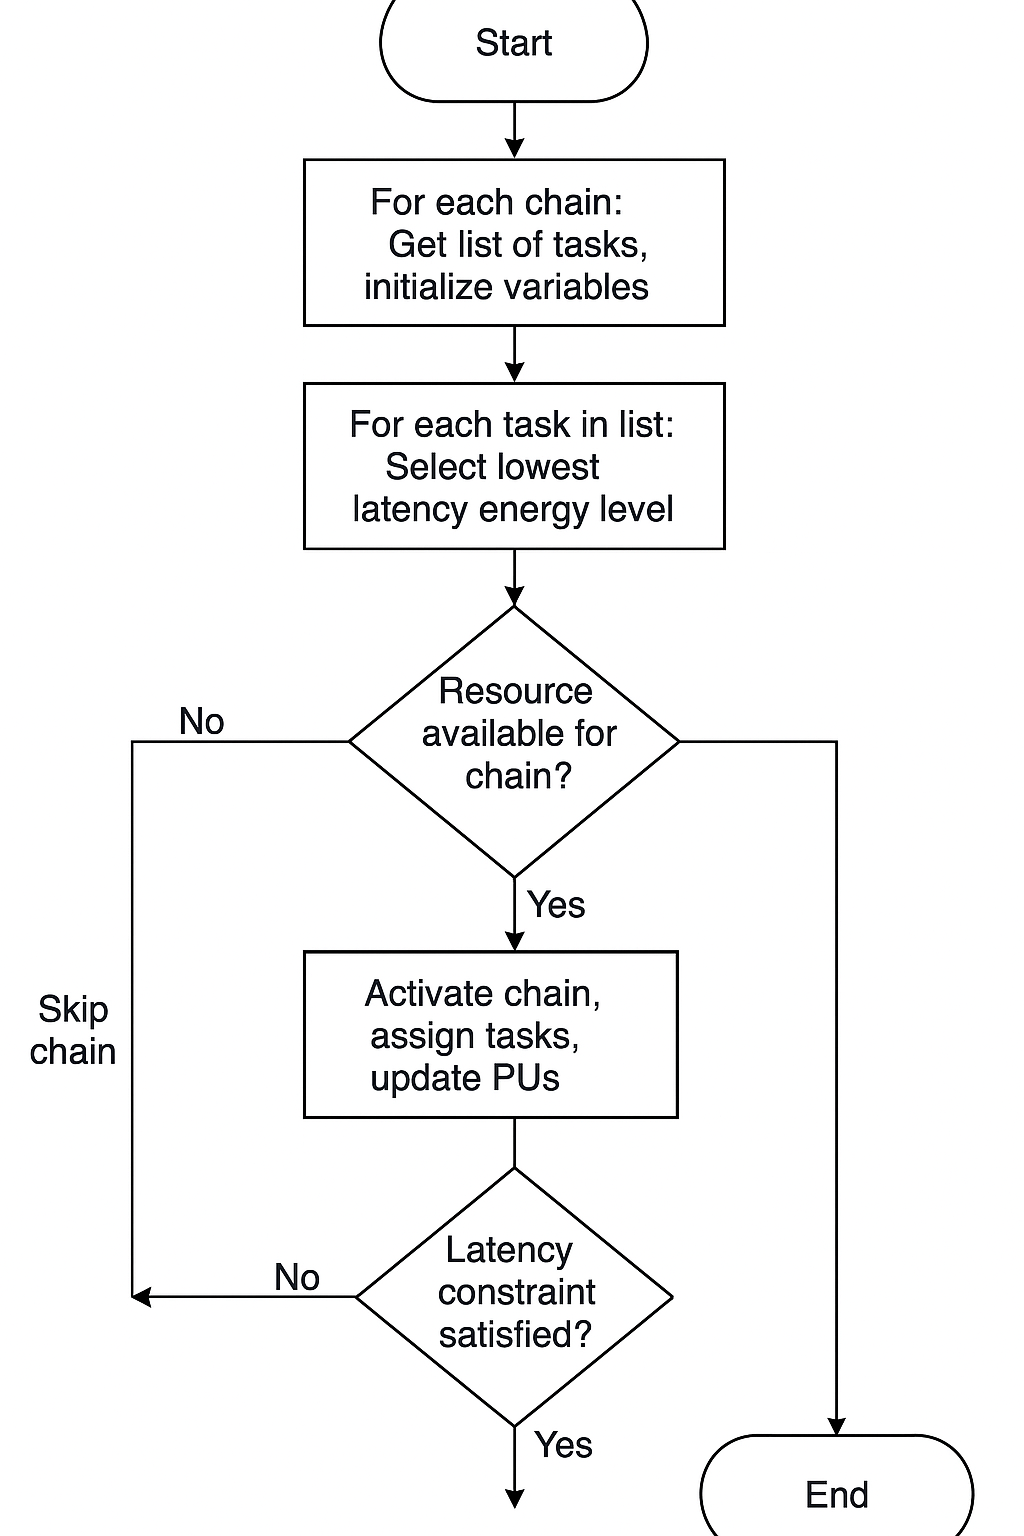

In [31]:
from IPython.display import Image, display
display(Image(filename='greedy.png'))